In [1]:
%load_ext autoreload
%autoreload 2

# Download Raw Obs

Since the organizers' processing wasn't perfect on the precipitation data, we will download the raw obs and dow our own version of forecast-like-observations for precipitation.

In [3]:
import calplot
import climetlab as cml
import datetime
import numpy as np
import pandas as pd
import pathlib
import xarray as xr

import climetlab_s2s_ai_challenge

In [4]:
cml.settings

cache-directory,'/tmp/CACHE-landryda/climetlab','/tmp/climetlab-landryda'
datasets-directories,['***HOME***.climetlab/datasets'],['***HOME***.climetlab/datasets']
layers-directories,['***HOME***.climetlab/layers'],['***HOME***.climetlab/layers']
maximum-cache-size,'10GB','10GB'
number-of-download-threads,5,5
plotting-options,{},{}
projections-directories,['***HOME***.climetlab/projections'],['***HOME***.climetlab/projections']
styles-directories,['***HOME***.climetlab/styles'],['***HOME***.climetlab/styles']


In [5]:
pr = cml.load_dataset('s2s-ai-challenge-observations', parameter=['pr']).to_xarray()

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data.  This dataset has been dowloaded from IRIDL. By downloading this data you also agree to the terms and conditions defined at https://iridl.ldeo.columbia.edu.


  0%|          | 0/1 [00:00<?, ?it/s]

pr.nc:   0%|          | 0.00/903M [00:00<?, ?B/s]

In [8]:
pr.to_netcdf('***BASEDIR***/pr_raw_obs.nc')

In [8]:
pr

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8154)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-28
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    pr         (time, latitude, longitude) float32 ...
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

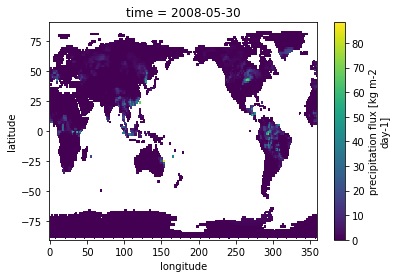

In [184]:
pr.sel(time='2008-05-30').pr.plot()

## Find dates with odd nulls

In [9]:
null_counts = pr.isnull().sum(dim=['latitude', 'longitude'])

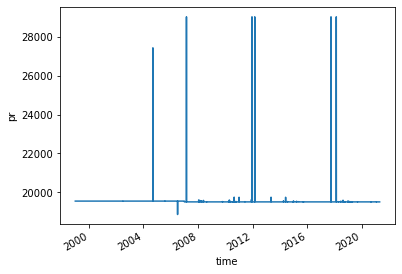

In [12]:
null_counts.pr.plot()

In [17]:
null_counts_pd = pd.Series(data=null_counts.pr.data, index=null_counts.time.data)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x2815.2 with 24 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b969883a970>,
       dtype=object))

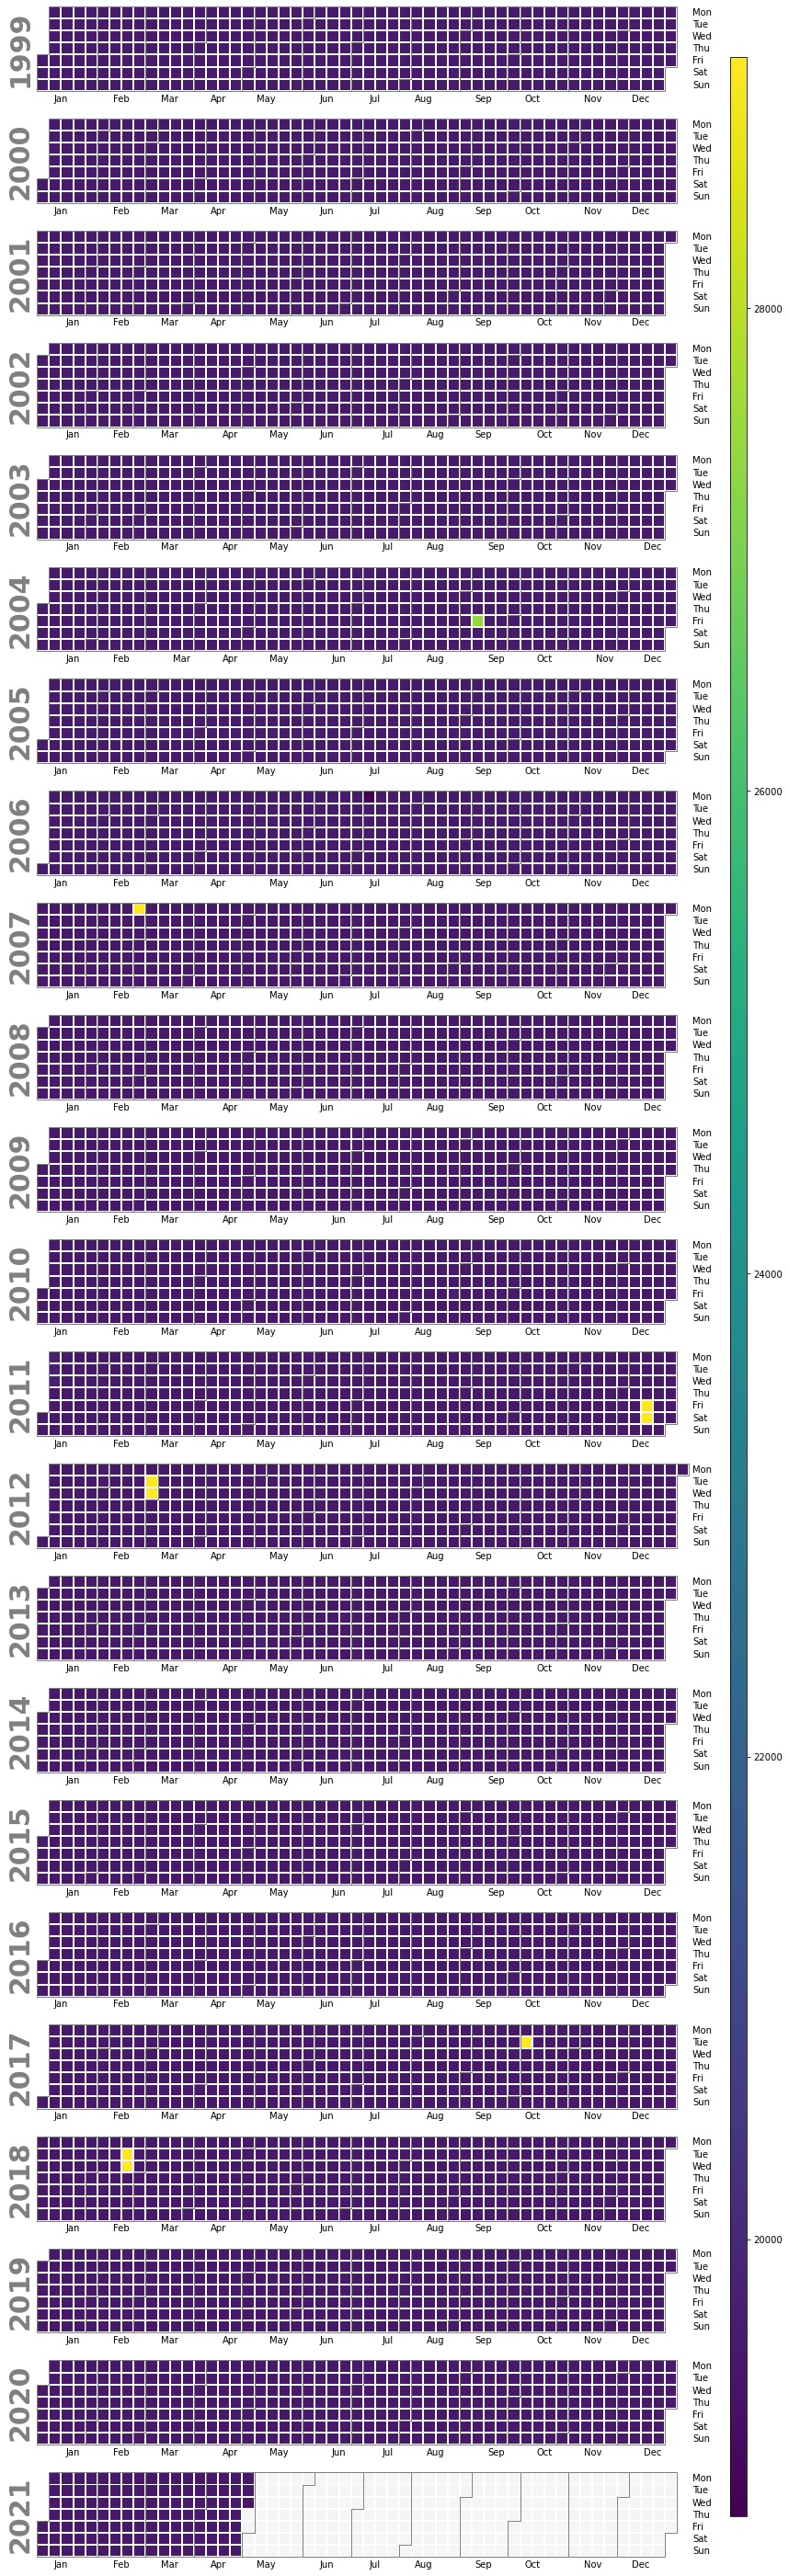

In [18]:
calplot.calplot(null_counts_pd)

There are problems in:
* september 04
* feb 08
* dec 11
* feb 12
* sept 17
* feb 18

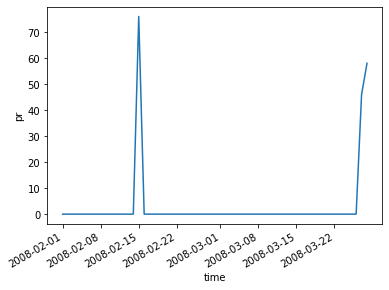

In [244]:
(pr.sel(time=slice('2008-02-01', '2008-03-28')).isnull().sum(dim=['latitude', 'longitude']) - pr.sel(time='2021-02-01').isnull().sum()).pr.plot()

In [41]:
months = [
    datetime.datetime(2004, 9, 1),
    datetime.datetime(2008, 2, 1),
    datetime.datetime(2011, 12, 1),
    datetime.datetime(2012, 2, 1),
    datetime.datetime(2017, 9, 1),
    datetime.datetime(2018, 2, 1),
]

dates_with_missing = []
for date in months:
    dates_with_missing.append(pr.sel(time=slice(date, date + datetime.timedelta(days=32))).isnull().sum(dim=['latitude', 'longitude']).idxmax().pr.data)

In [42]:
dates_with_missing

[array('2004-09-10T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2008-02-15T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2011-12-16T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2012-02-28T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2017-10-03T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2018-02-20T00:00:00.000000000', dtype='datetime64[ns]')]

In the calendar I counted 9 faulty dates so i'll just find the arxmax 9 times.

In [43]:
daily_nulls = pr.isnull().sum(dim=['latitude', 'longitude'])

In [50]:
for _ in range(9):
    date = daily_nulls.idxmax().pr.data
    print(date)
    daily_nulls = daily_nulls.sel(time=date)['pr'] = 0

2007-02-26T00:00:00.000000000


AttributeError: 'int' object has no attribute 'sel'

In [396]:
interpolated = pr.interpolate_na(dim='time', max_gap='365D')

In [397]:
null_counts = interpolated.isnull().sum(dim=['latitude', 'longitude'])

In [398]:
null_counts_pd = pd.Series(data=null_counts.pr, index=null_counts.time.data)

In [399]:
null_counts_pd

1999-01-01    19545
1999-01-02    19545
1999-01-03    19545
1999-01-04    19545
1999-01-05    19545
              ...  
2021-04-24    19504
2021-04-25    19504
2021-04-26    19504
2021-04-27    19504
2021-04-28    19504
Length: 8154, dtype: int64

(<Figure size 900x2815.2 with 24 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b96b54b45e0>,
       dtype=object))

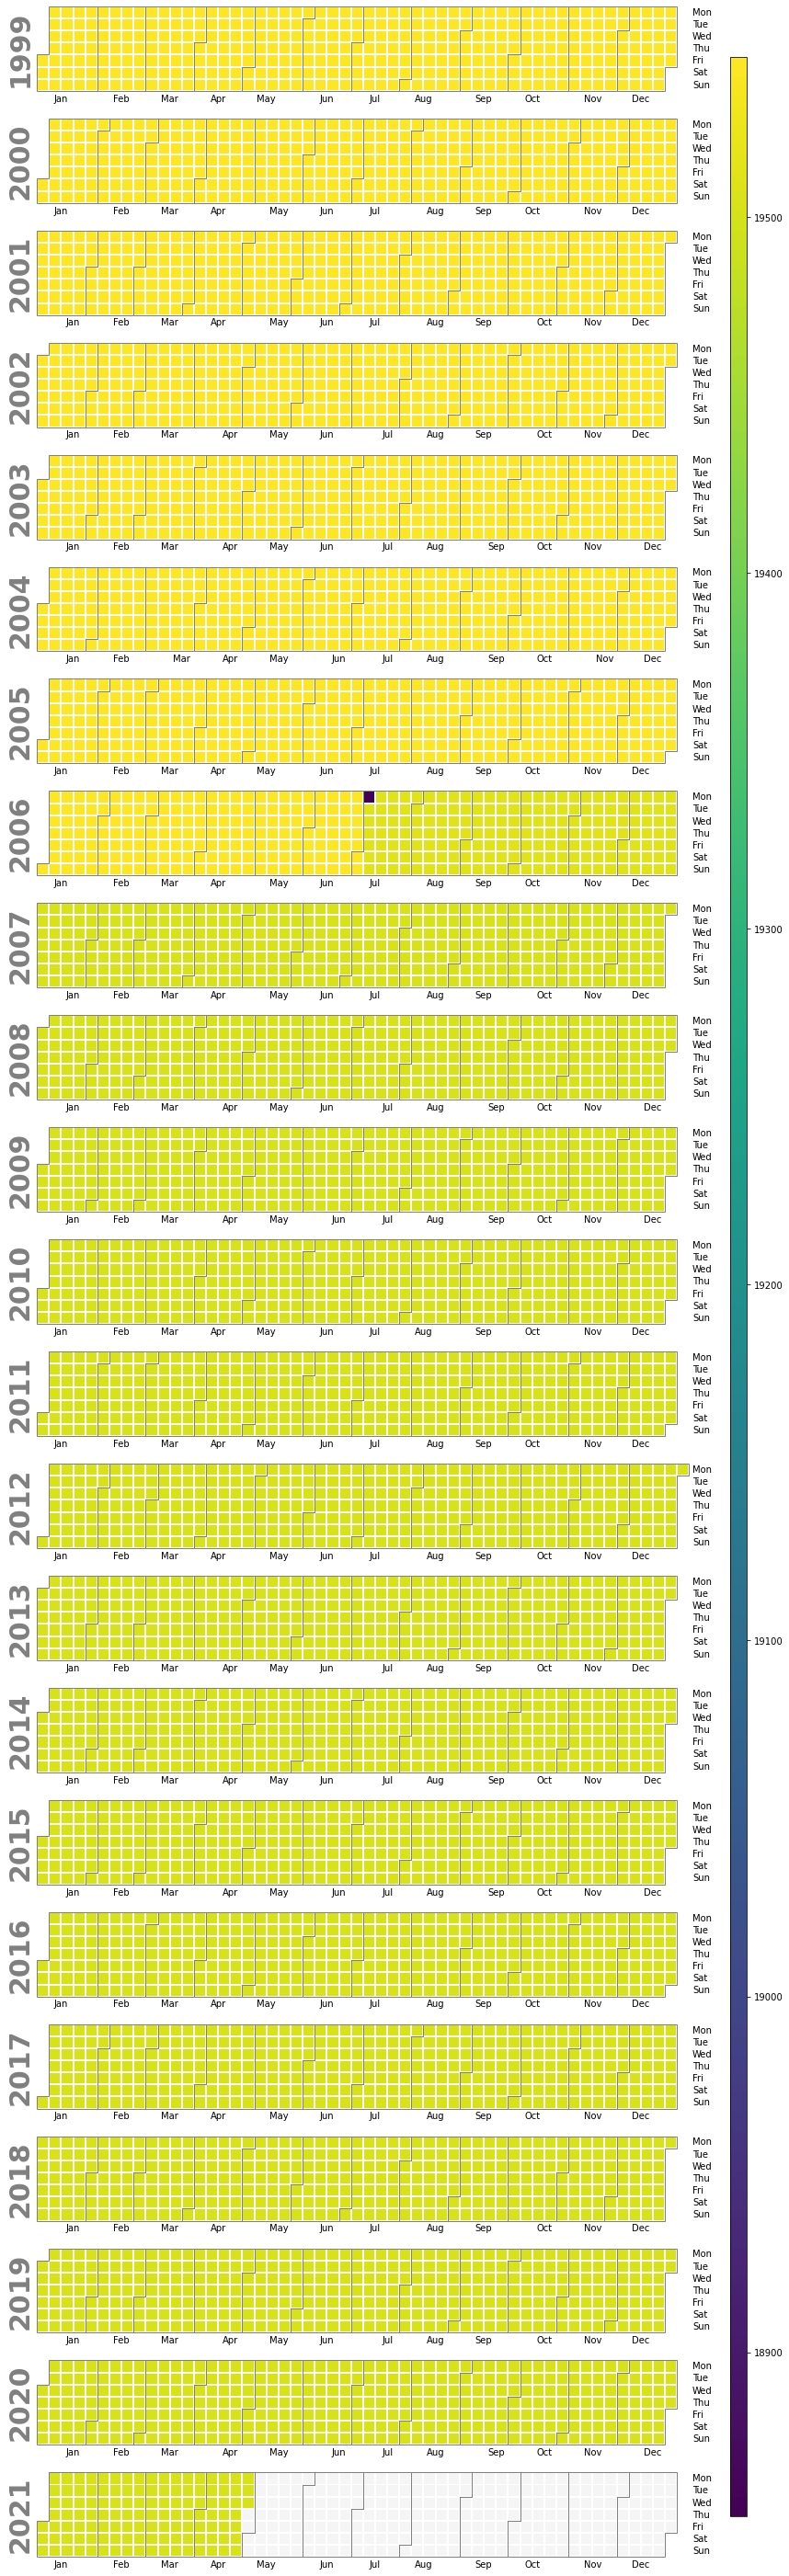

In [400]:
calplot.calplot(null_counts_pd)

## Fixing more weird dates

Here we see that there are less nans than usual in july of 06 and more than usual in jan of 2011. Let's validate those manually.

In [401]:
date = datetime.datetime(2006, 7, 1)
pr.sel(time=slice(date, date + datetime.timedelta(days=32))).isnull().sum(dim=['latitude', 'longitude']).pr.idxmin()

<xarray.DataArray 'time' ()>
array('2006-07-03T00:00:00.000000000', dtype='datetime64[ns]')

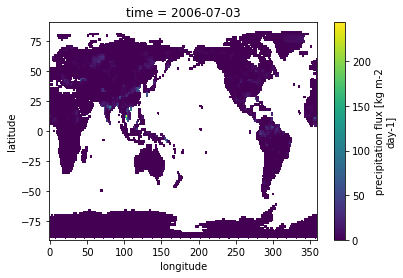

In [402]:
pr.sel(time='2006-07-03').pr.plot()

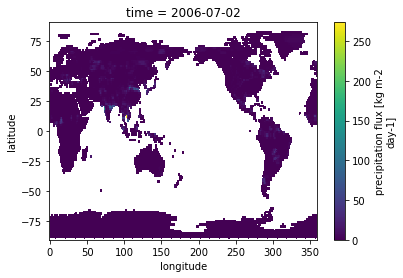

In [403]:
pr.sel(time='2006-07-02').pr.plot()

Looks like an interpolation glitch or something. I'll just reapply the land mask to fix it.

In [404]:
pr.sel(time='2006-07-03').where(pr.sel(time='2006-07-02').isnull())['pr']= np.nan

In [405]:
faulty_pr = pr.sel(time='2006-07-03').pr

In [421]:
sea_mask = interpolated.sel(time='2001-01-01').isnull().pr

In [422]:
sea_mask.sum()

<xarray.DataArray 'pr' ()>
array(19545)
Coordinates:
    time     datetime64[ns] 2001-01-01

In [408]:
faulty_pr.where(~sea_mask, np.nan).isnull().sum()

<xarray.DataArray 'pr' ()>
array(19545)

In [409]:
remasked = interpolated.where(~sea_mask, np.nan)

In [410]:
sea_mask_null_count = remasked.isnull().sum(dim=['latitude', 'longitude'])

In [411]:
sea_mask_null_count

<xarray.Dataset>
Dimensions:  (time: 8154)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-28
Data variables:
    pr       (time) int64 19545 19545 19545 19545 ... 19545 19545 19545 19545

In [412]:
sea_mask_null_count_pd = pd.Series(sea_mask_null_count.pr, index=sea_mask_null_count.time.data)

In [413]:
sea_mask_null_count_pd

1999-01-01    19545
1999-01-02    19545
1999-01-03    19545
1999-01-04    19545
1999-01-05    19545
              ...  
2021-04-24    19545
2021-04-25    19545
2021-04-26    19545
2021-04-27    19545
2021-04-28    19545
Length: 8154, dtype: int64

(<Figure size 720x2815.2 with 23 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b96b5f7d970>,
       dtype=object))

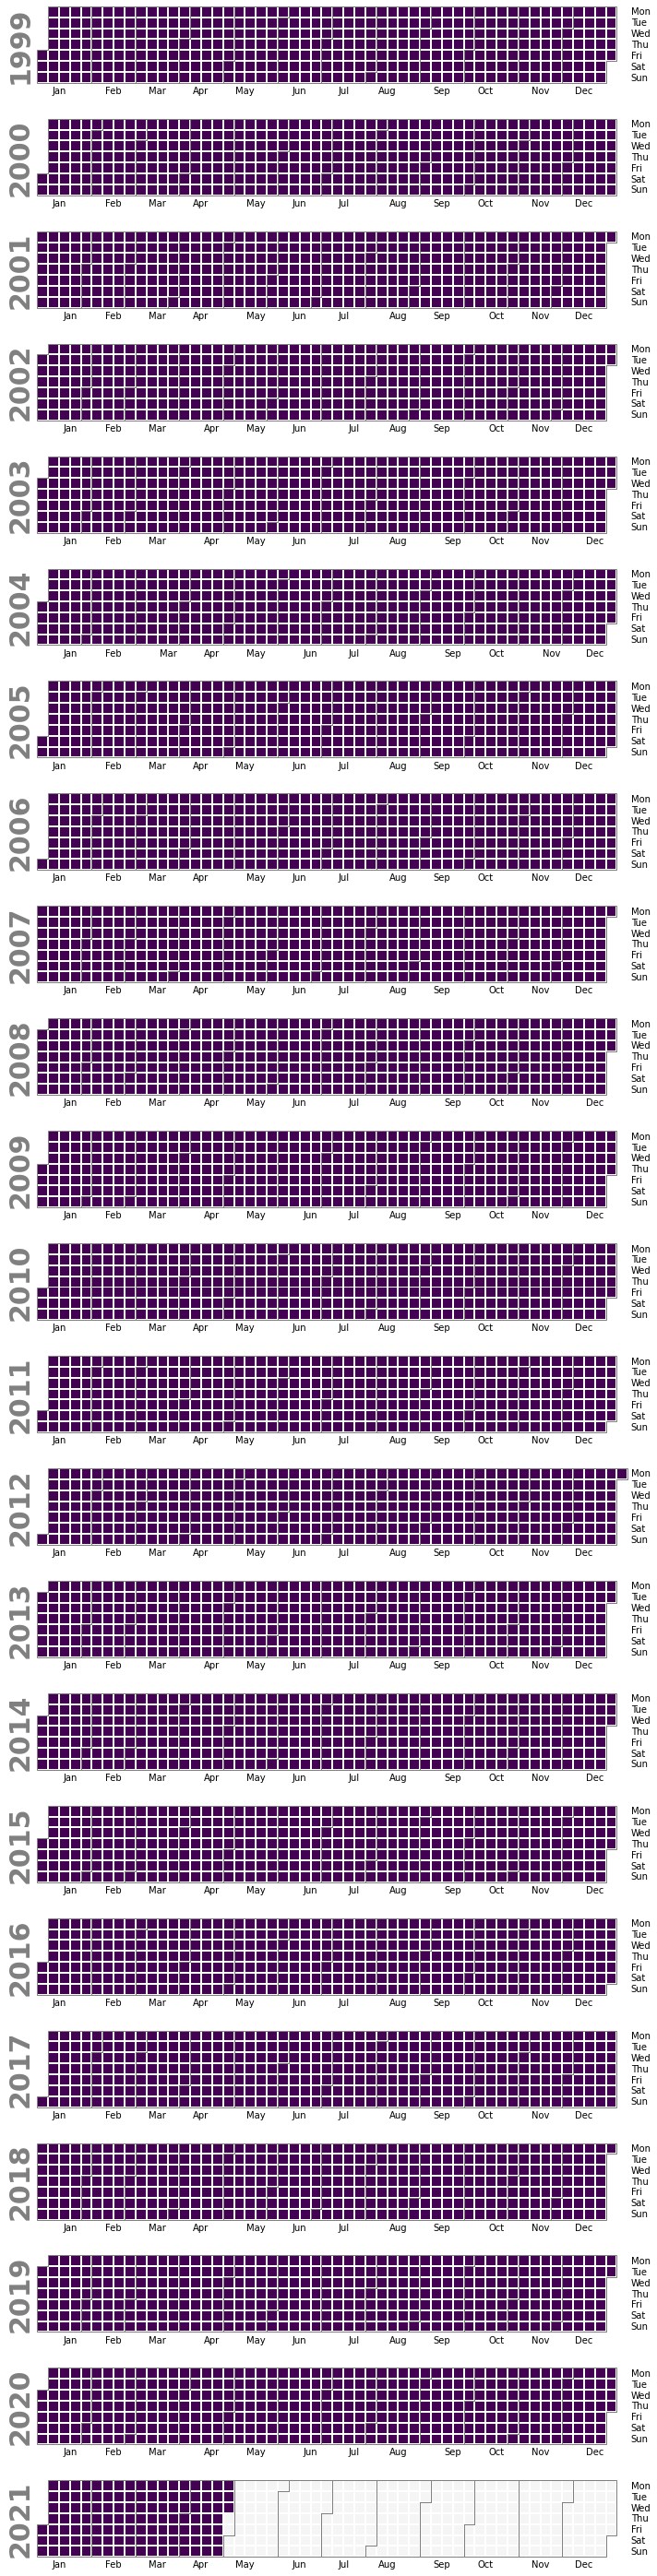

In [414]:
calplot.calplot(sea_mask_null_count_pd)

So that fixed the july of 06 problem. Now for the problem in jan of 11. Also a new gap emerged: in may of 08.

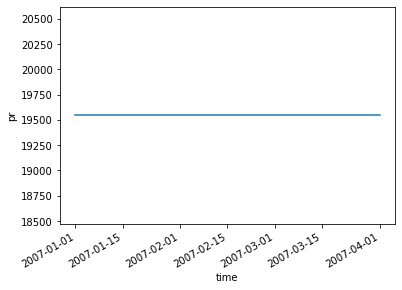

In [307]:
remasked.sel(time=slice('2007-01-01', '2007-04-01')).isnull().sum(dim=['latitude', 'longitude']).pr.plot()

In [308]:
remasked.isnull().sum(dim=['latitude', 'longitude']).idxmax()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    pr       datetime64[ns] 1999-01-01

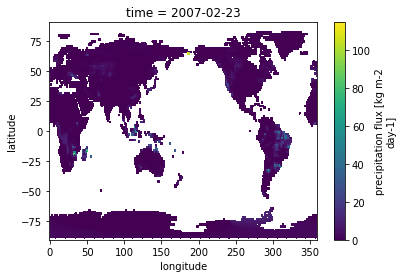

In [309]:
remasked.sel(time='2007-02-23').pr.plot()

In [310]:
remasked.sel(time='2011-01-05').isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 2011-01-05
Data variables:
    pr       int64 19545

In [311]:
remasked.sel(time='2011-01-04').isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 2011-01-04
Data variables:
    pr       int64 19545

In [423]:
null05 = interpolated.sel(time='2011-02-23').isnull()

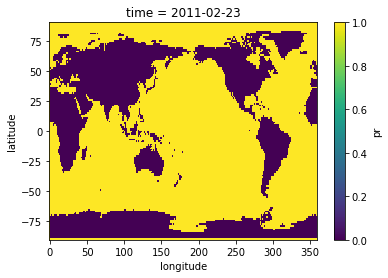

In [424]:
null05.pr.plot()

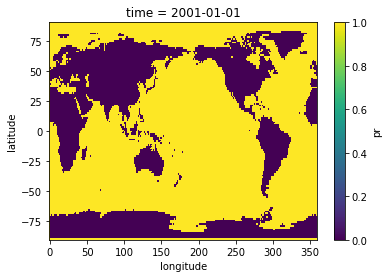

In [425]:
sea_mask.plot()

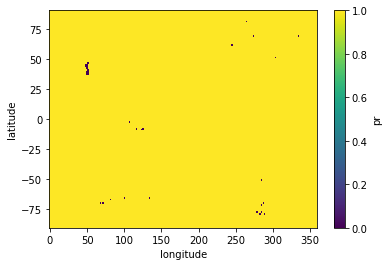

In [427]:
(pr.sel(time='2015-01-04').pr.isnull() ^ ~sea_mask).plot()

A part of west africa is missing, from 2008-05-21 to 2008-05-30.
Once again I think I'll just extend the interpolation... We don't want nans in there.

In [321]:
remasked.isel(time=0).pr

<xarray.DataArray 'pr' (latitude: 121, longitude: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time       datetime64[ns] 1999-01-01
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Attributes:
    pointwidth:     0
    long_name:      precipitation flux
    standard_name:  precipitation_flux
    units:          kg m-2 day-1

In [322]:
pr.isel(time=0).pr

<xarray.DataArray 'pr' (latitude: 121, longitude: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time       datetime64[ns] 1999-01-01
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Attributes:
    pointwidth:     0
    long_name:      precipitation flux
    standard_name:  precipitation_flux
    units:          kg m-2 day-1

In [375]:
diff = pr.isnull() != remasked.isnull()

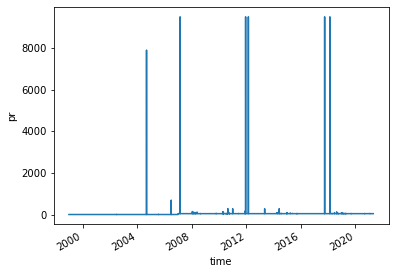

In [376]:
diff.sum(dim=['latitude', 'longitude']).pr.plot()

In [377]:
diff

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8154)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-28
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    pr         (time, latitude, longitude) bool False False ... False False

In [333]:
remasked.assign({'pr_interpolated': diff.pr}).to_netcdf('***BASEDIR***pr-obs-interpolated.nc')

In [331]:
remasked

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8154)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-28
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    pr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

# Redo forecast-like obs using the fixed precip

In [336]:
fix_pr = xr.open_dataset('***BASEDIR***pr-obs-interpolated.nc')

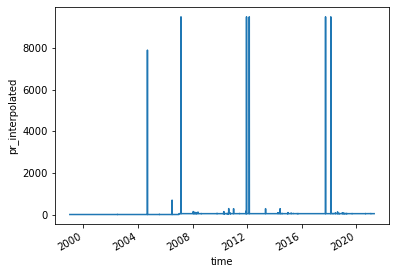

In [379]:
fix_pr.pr_interpolated.sum(dim=['latitude', 'longitude']).plot()

In [345]:
forecast_path = pathlib.Path('***BASEDIR***/training-input/')

In [346]:
forecast_files = [f for f in forecast_path.iterdir() if 'ecmwf' in f.stem and 'tp' in f.stem]

In [347]:
forecast_files[:10]

[PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20201015.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20200910.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20201231.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20200416.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20200625.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20200319.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20201001.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20200528.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20200507.nc'),
 PosixPath('***BASEDIR***/training-input/ecmwf-hindcast-tp-20201112.nc')]

In [389]:
forecast = xr.open_dataset(forecast_files[0])

In [390]:
newobs = climetlab_s2s_ai_challenge.extra.forecast_like_observations(forecast, fix_pr.drop('pr_interpolated'))

In [391]:
newobs

<xarray.Dataset>
Dimensions:        (forecast_time: 20, latitude: 121, lead_time: 47, longitude: 240)
Coordinates:
  * lead_time      (lead_time) timedelta64[ns] 0 days 1 days ... 45 days 46 days
    valid_time     (forecast_time, lead_time) datetime64[ns] 2000-10-15 ... 2...
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * forecast_time  (forecast_time) datetime64[ns] 2000-10-15 ... 2019-10-15
Data variables:
    tp             (forecast_time, lead_time, latitude, longitude) float32 na...
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile
    function:             climetlab_s2s_ai_challenge.extra.forecast_like_obse...

In [392]:
newmask = climetlab_s2s_ai_challenge.extra.forecast_like_observations(forecast, fix_pr.drop('pr'))

In [393]:
newmask

<xarray.Dataset>
Dimensions:          (forecast_time: 20, latitude: 121, lead_time: 47, longitude: 240)
Coordinates:
    valid_time       (forecast_time, lead_time) datetime64[ns] 2000-10-15 ......
  * latitude         (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude        (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * forecast_time    (forecast_time) datetime64[ns] 2000-10-15 ... 2019-10-15
  * lead_time        (lead_time) timedelta64[ns] 0 days 1 days ... 46 days
Data variables:
    pr_interpolated  (forecast_time, lead_time, latitude, longitude) bool Fal...
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile
    function:             climetlab_s2s_ai_challenge.extra.forecast_like_obse...

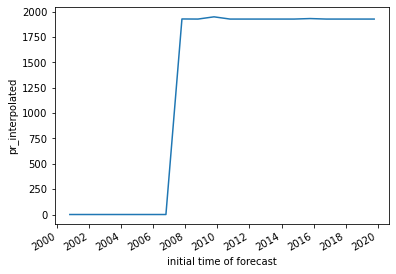

In [394]:
newmask.pr_interpolated.sum(dim=['latitude', 'longitude', 'lead_time']).plot()

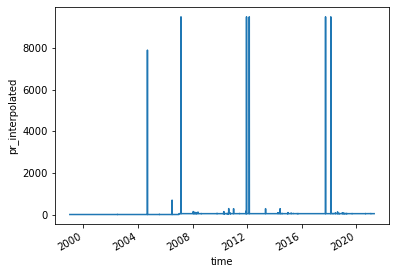

In [395]:
fix_pr.pr_interpolated.sum(dim=['latitude', 'longitude']).plot()